# Import

In [1]:
!pip install scikit-fuzzy
!pip install control

import numpy as np
import control as ct
import matplotlib.pyplot as plt
from scipy import signal
import skfuzzy as fuzzy
from skfuzzy import control as ctrl
import control.matlab as control
import gzip
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import gdown
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
import numpy as np
import itertools
import matplotlib.pyplot as plt
import gdown
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.6/549.6 kB 7.4 MB/s eta 0:00:00


# Question 1

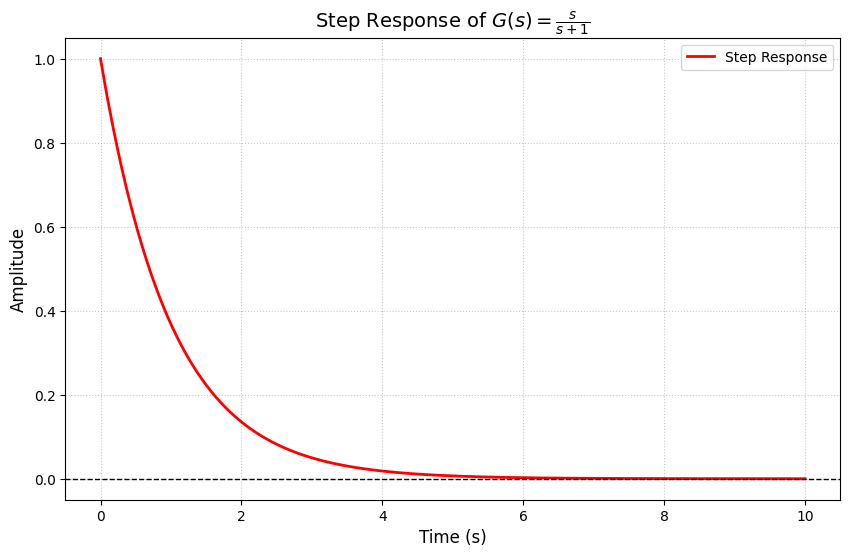

In [2]:
# Define your transfer function: G(s) = s / (s + 1)
sys = ct.TransferFunction([1, 0], [1, 1])

# Compute step response (with optional custom time vector)
T = np.linspace(0, 10, 1000)  # Time from 0 to 10 seconds (optional)
time, response = ct.step_response(sys, T)  # Use `step_response` instead of `step`

# Plot settings
plt.figure(figsize=(10, 6))
plt.plot(time, response, color='red', linewidth=2, label='Step Response')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)  # Steady-state line
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Amplitude', fontsize=12)
plt.title('Step Response of $G(s) = \\frac{s}{s+1}$', fontsize=14)
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend()
plt.show()

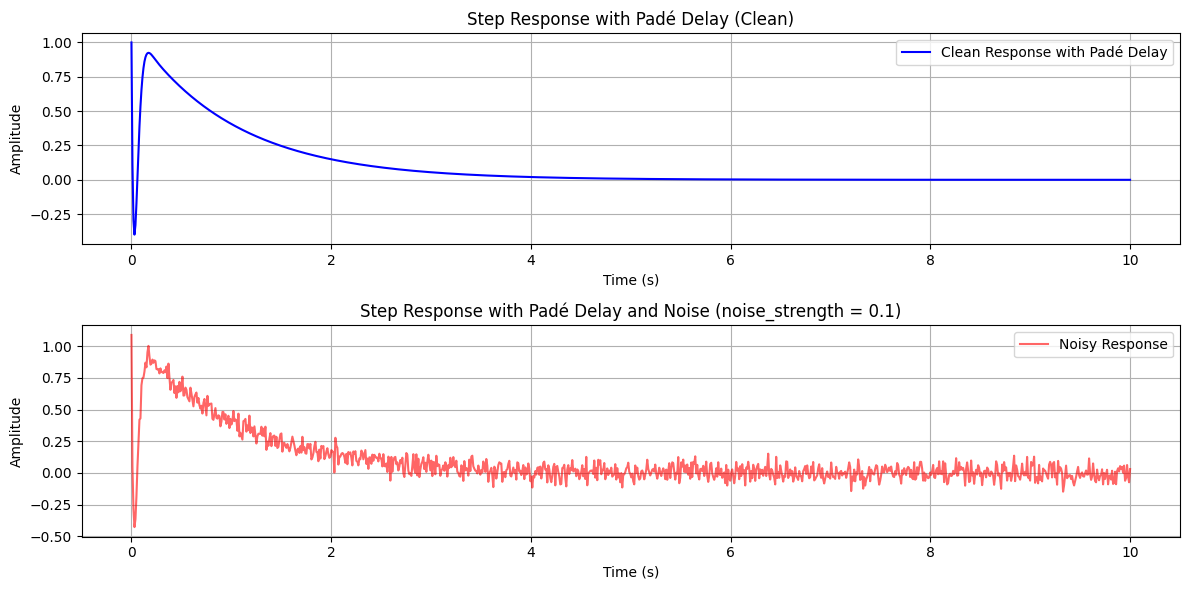

In [20]:
import control as ct
import matplotlib.pyplot as plt
import numpy as np

# Original system: G(s) = s/(s+1)
sys = ct.TransferFunction([1,0], [1, 1])

# Define delay τ = 2 seconds and Padé order (e.g., 3rd order)
tau = 0.1
order = 2
delay_num, delay_den = ct.pade(tau, order)  # Get numerator/denominator of Padé approximation

# Create the delay transfer function
delay_sys = ct.TransferFunction(delay_num, delay_den)

# Combine the original system with the delay
#delayed_sys = ct.series(sys, delay_sys)
delayed_sys = sys * delay_sys
# Compute step response
time = np.linspace(0, 10, 1000)
time_pade, response_pade = ct.step_response(delayed_sys, time)

# Add Gaussian noise to the response
noise_strength = 0.05  # Standard deviation of the noise
noise = np.random.normal(0, noise_strength, len(response_pade))
noisy_response = response_pade + noise

# Create a figure with two subplots
plt.figure(figsize=(12, 6))

# Subplot 1: Clean Response
plt.subplot(2, 1, 1)  # 2 rows, 1 column, first subplot
plt.plot(time_pade, response_pade, 'b', label='Clean Response with Padé Delay')
plt.title('Step Response with Padé Delay (Clean)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()

# Subplot 2: Noisy Response
plt.subplot(2, 1, 2)  # 2 rows, 1 column, second subplot
plt.plot(time_pade, noisy_response, 'r', alpha=0.6, label='Noisy Response')
plt.title(f'Step Response with Padé Delay and Noise (noise_strength = {0.1})')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [15]:
def assess_system(output, time):
    final_value = output[-1]
    settling_duration = None
    rise_duration = None
    max_value = max(output)
    overshoot_ratio = (max_value - final_value) / final_value * 100 if final_value != 0 else 0

    # Calculating settling time (2%)
    tolerance = 0.02 * final_value
    for idx in range(len(output)):
        if abs(output[idx] - final_value) <= tolerance:
            settling_duration = time[idx]
            break

    # Calculating rise time (10% to 90%)
    normalized_output = (output - output[0]) / (final_value - output[0]) if final_value != output[0] else output
    start_point, end_point = None, None
    for i, value in enumerate(normalized_output):
        if start_point is None and value >= 0.1:
            start_point = time[i]
        if value >= 0.9:
            end_point = time[i]
            break
    if start_point is not None and end_point is not None:
        rise_duration = end_point - start_point

    return {
        'Overshoot (%)': overshoot_ratio,
        'Settling Time (s)': settling_duration,
        'Rise Time (s)': rise_duration,
        'Peak': max_value,
        'Final Value': final_value
    }

In [16]:
def ziegler_nichols_pid_tuning(control_system):
    gain_margin, phase_margin, freq_gain, freq_phase = control.margin(control_system)
    max_gain = gain_margin
    oscillation_period = 2 * np.pi / freq_gain

    k_p = 0.6 * max_gain
    k_i_time = oscillation_period / 2
    k_d_time = oscillation_period / 8

    k_i = k_p / k_i_time
    k_d = k_p * k_d_time

    return k_p, k_i, k_d

def build_fuzzy_pid_controller():
    # Define input and output variables
    error_input = ctrl.Antecedent(np.linspace(-1, 1, 7), 'error')
    delta_error_input = ctrl.Antecedent(np.linspace(-1, 1, 7), 'delta_error')
    pid_output = ctrl.Consequent(np.linspace(-1, 1, 7), 'output')

    # Define membership functions
    labels = ['nb', 'nm', 'ns', 'z', 'ps', 'pm', 'pb']
    error_input.automf(names=labels)
    delta_error_input.automf(names=labels)
    pid_output.automf(names=labels)

    # Define fuzzy rules
    fuzzy_rules = []
    for i in range(7):
        for j in range(7):
            fuzzy_rules.append(ctrl.Rule(
                error_input[labels[i]] & delta_error_input[labels[j]],
                pid_output[labels[min(6, max(0, i + j - 3))]]
            ))

    # Build the fuzzy control system
    fuzzy_pid_system = ctrl.ControlSystem(fuzzy_rules)
    return ctrl.ControlSystemSimulation(fuzzy_pid_system)


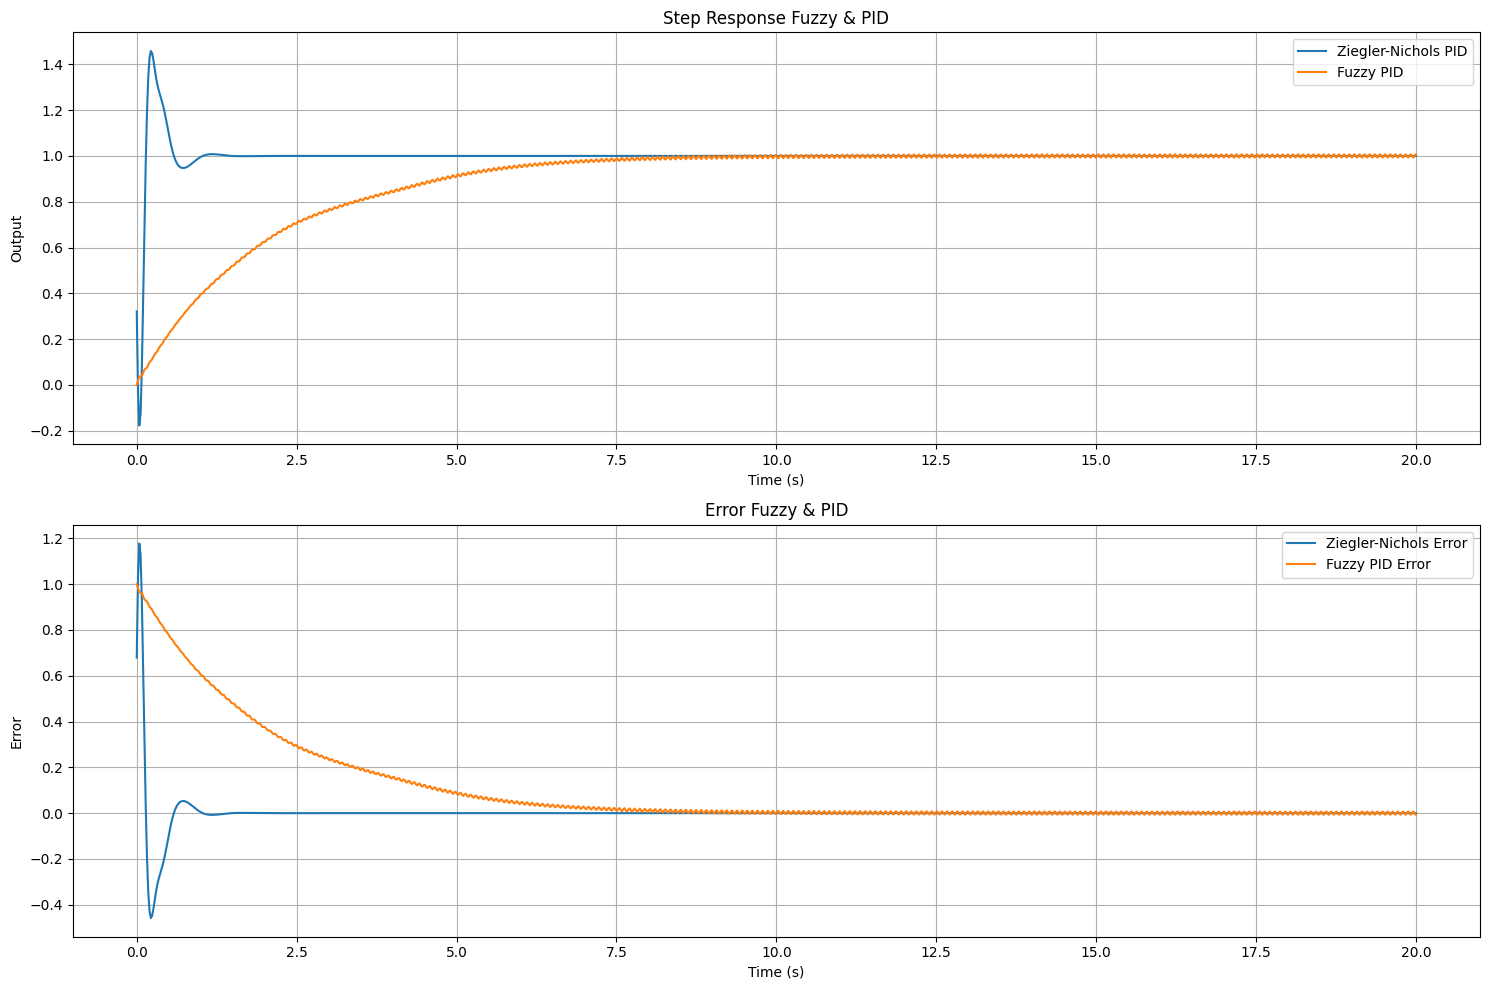

Ziegler-Nichols PID Performance:
Overshoot (%): 45.793
Settling Time (s): 0.561
Rise Time (s): 0.020
Peak: 1.458
Final Value: 1.000

Fuzzy PID Performance:
Overshoot (%): 0.000
Settling Time (s): 7.347
Rise Time (s): 4.645
Peak: 1.007
Final Value: 1.007


In [19]:
t = np.linspace(0, 20, 1000)
 # Creating
sys = ct.TransferFunction([1], [1, 1])

tau = 0.5
order = 2
delay_num, delay_den = ct.pade(tau, order)

delay_sys = ct.TransferFunction(delay_num, delay_den)

Kp_zn, Ki_zn, Kd_zn = ziegler_nichols_pid_tuning(delayed_sys)
controller_zn = ct.TransferFunction([Kd_zn, Kp_zn, Ki_zn], [1, 0])
closed_loop_zn = ct.feedback(controller_zn * delayed_sys, 1)
t_zn, y_zn = ct.step_response(closed_loop_zn, T=t)


fuzzy_pid_simulation = build_fuzzy_pid_controller()
y_simulated = np.zeros_like(t)
previous_error = 0
for step in range(len(t) - 1):
    current_error = 1 - y_simulated[step - 1] if step > 0 else 1
    delta_error = (current_error - previous_error) / (t[1] - t[0])

    fuzzy_pid_simulation.input['error'] = np.clip(current_error, -1, 1)
    fuzzy_pid_simulation.input['delta_error'] = np.clip(delta_error, -1, 1)
    fuzzy_pid_simulation.compute()

    dt = t[1] - t[0]
    y_simulated[step + 1] = y_simulated[step] + fuzzy_pid_simulation.output['output'] * dt
    previous_error = current_error


zn_metrics = assess_system(y_zn, t)
fuzzy_metrics = assess_system(y_simulated, t)


plt.figure(figsize=(15, 10))
plt.subplot(211)
plt.plot(t, y_zn, label='Ziegler-Nichols PID')
plt.plot(t, y_simulated, label='Fuzzy PID')
plt.title('Step Response Fuzzy & PID')
plt.xlabel('Time (s)')
plt.ylabel('Output')
plt.legend()
plt.grid(True)

plt.subplot(212)
error_zn = 1 - y_zn
error_fuzzy = 1 - y_simulated
plt.plot(t, error_zn, label='Ziegler-Nichols Error')
plt.plot(t, error_fuzzy, label='Fuzzy PID Error')
plt.title('Error Fuzzy & PID')
plt.xlabel('Time (s)')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


print("Ziegler-Nichols PID Performance:")
for key, value in zn_metrics.items():
    print(f"{key}: {value:.3f}")

print("\nFuzzy PID Performance:")
for key, value in fuzzy_metrics.items():
    print(f"{key}: {value:.3f}")

# Question 3

In [ ]:
import gdown

In [ ]:

output_file = "ballbeam.dat"
gdown.download(f"https://drive.google.com/uc?id=1sGH6au2APRcASpBx_MDXKIqZ1C1QHQxN","ballbeam.dat")


Downloading...
From: https://drive.google.com/uc?id=1sGH6au2APRcASpBx_MDXKIqZ1C1QHQxN
To: /content/ballbeam.dat
100%|██████████| 7.37k/7.37k [00:00<00:00, 6.88MB/s]


'ballbeam.dat'

In [ ]:
class AdaptiveFuzzyUnit(Layer):
    def __init__(self, num_rules=3, **kwargs):
        super(AdaptiveFuzzyUnit, self).__init__(**kwargs)
        self.num_rules = num_rules

    def build(self, input_shape):
        features = input_shape[-1]

        self.cluster_centers = self.add_weight(
            name='cluster_centers',
            shape=(features, self.num_rules),
            initializer='glorot_uniform',
            trainable=True
        )

        self.spread_factors = self.add_weight(
            name='spread_factors',
            shape=(features, self.num_rules),
            initializer='ones',
            trainable=True
        )

        self.rule_weights = self.add_weight(
            name='rule_weights',
            shape=(features * self.num_rules, 1),
            initializer='random_normal',
            trainable=True
        )

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        feature_dim = tf.shape(inputs)[1]

        input_expanded = tf.expand_dims(inputs, 2)
        deviation = input_expanded - tf.expand_dims(self.cluster_centers, 0)
        spread_values = tf.abs(self.spread_factors) + 1e-3
        rule_activation = tf.exp(-tf.square(deviation)/(2 * spread_values))

        flat_activations = tf.reshape(rule_activation, [batch_size, -1])
        return tf.matmul(flat_activations, self.rule_weights)

Starting system analysis...
Dataset dimensions: (1000, 2)
Input shape: (997, 3, 2)
Output shape: (997,)
Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.4020 - val_loss: 0.4087
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.4012 - val_loss: 0.3977
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3850 - val_loss: 0.3870
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3713 - val_loss: 0.3767
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3636 - val_loss: 0.3664
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3475 - val_loss: 0.3566
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3328 - val_loss: 0.3471
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3380 - val_loss: 0.3377
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3153 - val_loss: 0.3284
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3088 - val_loss: 0.3195
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5

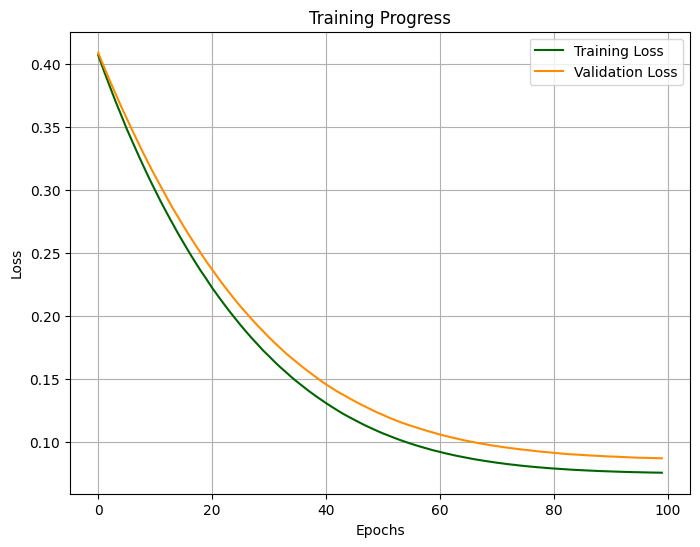

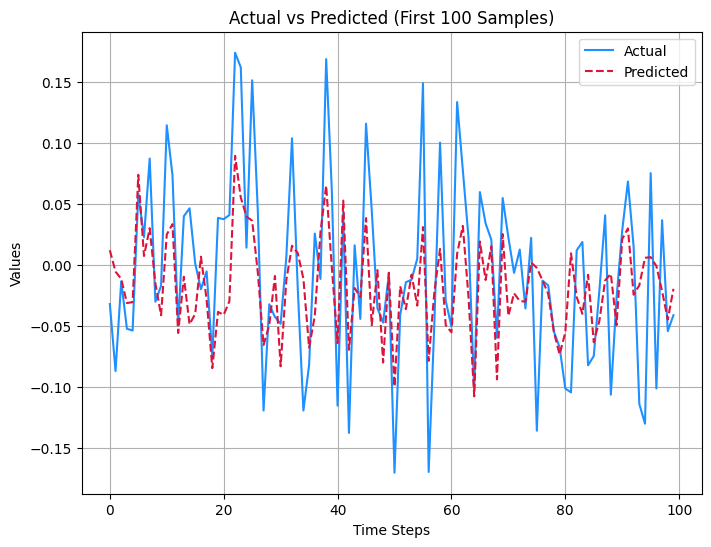

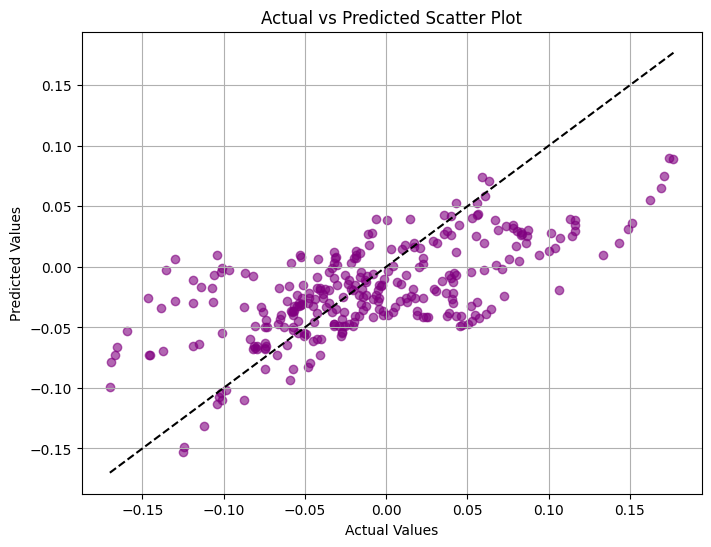

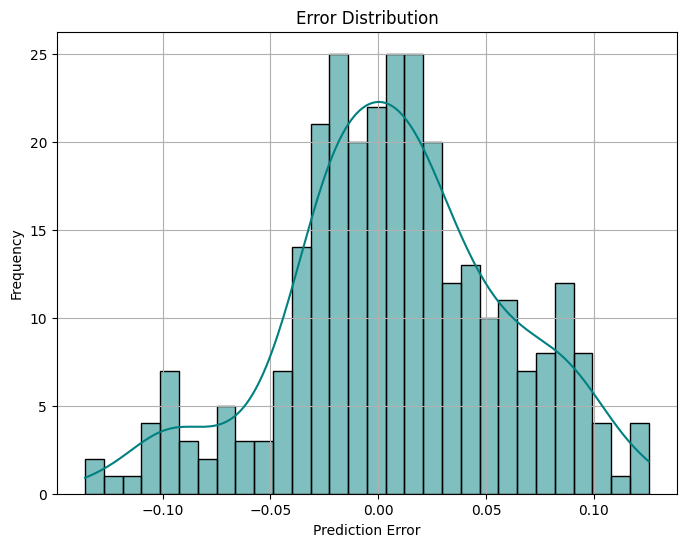


Performance Metrics:
MSE: 0.0027
RMSE: 0.0515
MAE: 0.0398


In [ ]:
# Function to extract data from gzip file
def load_compressed_data(filepath):
    with gzip.open(filepath, 'rt') as f:
        return np.loadtxt(f)

# Function to generate sequences
def generate_sequences(data, time_window):
    sequences, targets = [], []
    for i in range(len(data)-time_window):
        sequences.append(data[i:i+time_window])
        targets.append(data[i+time_window, 1])
    return np.array(sequences), np.array(targets)

# Function to build a fuzzy neural network
def build_fuzzy_network(input_dim, num_rules=3):
    input_layer = Input(shape=(input_dim,))
    fuzzy_layer = Dense(1, activation="linear")(input_layer)
    return tf.keras.Model(inputs=input_layer, outputs=fuzzy_layer)

# Main function to analyze the system
def analyze_system(data_filepath, time_window=3):
    try:
        # Load and preprocess data
        raw_data = load_compressed_data(data_filepath)
        print("Dataset dimensions:", raw_data.shape)

        feature_scaler = MinMaxScaler((-1, 1))
        target_scaler = MinMaxScaler((-1, 1))

        normalized_data = np.zeros_like(raw_data)
        normalized_data[:, 0] = feature_scaler.fit_transform(raw_data[:, 0].reshape(-1, 1)).flatten()
        normalized_data[:, 1] = target_scaler.fit_transform(raw_data[:, 1].reshape(-1, 1)).flatten()

        X_data, y_data = generate_sequences(normalized_data, time_window)
        print("Input shape:", X_data.shape)
        print("Output shape:", y_data.shape)

        X_train, X_test, y_train, y_test = train_test_split(
            X_data, y_data, test_size=0.3, random_state=73
        )

        fuzzy_model = build_fuzzy_network(time_window)
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        fuzzy_model.compile(optimizer=optimizer, loss='mean_squared_error')

        early_stop = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )

        training_results = fuzzy_model.fit(
            X_train[:, :, 0],
            y_train,
            epochs=100,
            batch_size=64,
            validation_data=(X_test[:, :, 0], y_test),
            callbacks=[early_stop],
            verbose=1
        )

        predictions = fuzzy_model.predict(X_test[:, :, 0])

        actual_values = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
        predicted_values = target_scaler.inverse_transform(predictions).flatten()

        residuals = actual_values - predicted_values
        mse_value = np.mean(residuals**2)
        rmse_value = np.sqrt(mse_value)
        mae_value = np.mean(np.abs(residuals))

        # Plot 1: Training Loss Curve
        plt.figure(figsize=(8, 6))
        plt.plot(training_results.history['loss'], color='#006400', label='Training Loss')
        plt.plot(training_results.history['val_loss'], color='#FF8C00', label='Validation Loss')
        plt.title('Training Progress')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Plot 2: Actual vs Predicted (First 100 Samples)
        plt.figure(figsize=(8, 6))
        plt.plot(actual_values[:100], color='#1E90FF', label='Actual')
        plt.plot(predicted_values[:100], color='#DC143C', linestyle="--", label='Predicted')
        plt.title('Actual vs Predicted (First 100 Samples)')
        plt.xlabel('Time Steps')
        plt.ylabel('Values')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Plot 3: Scatter Plot of Actual vs Predicted
        plt.figure(figsize=(8, 6))
        plt.scatter(actual_values, predicted_values, color='#800080', alpha=0.6)
        plt.plot([actual_values.min(), actual_values.max()],
                 [actual_values.min(), actual_values.max()], 'k--')
        plt.title('Actual vs Predicted Scatter Plot')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.grid(True)
        plt.show()

        # Plot 4: Histogram of Prediction Errors
        plt.figure(figsize=(8, 6))
        sns.histplot(residuals, bins=30, kde=True, color='#008080')  # Teal
        plt.title('Error Distribution')
        plt.xlabel('Prediction Error')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()

        print('\nPerformance Metrics:')
        print(f'MSE: {mse_value:.4f}')
        print(f'RMSE: {rmse_value:.4f}')
        print(f'MAE: {mae_value:.4f}')

        return fuzzy_model, training_results, (mse_value, rmse_value, mae_value)

    except Exception as ex:
        print(f"Encountered an error: {ex}")
        return None, None, None

print("Starting system analysis...")
data_filepath = '/content/ballbeam.dat'  # Use the correct file path
fuzzy_model, training_results, metrics = analyze_system(data_filepath)

# Question 4 (Matlab code)

In [ ]:
% ----- All Functions of this Question are in this single Matlab File -----
% Kasra Davoodi
% Question 4
% -------------------------------------------------------------------------
% ---- Main Part of the Code ----
% Define constants
M = 15; % Number of membership functions (fuzzy rules)
num_train = 300; % Number of training data points
total_data_points = 800; % Total number of data points
lambda = 0.95; % Forgetting factor for RLS
initial_weight_variance = 50; % Initial variance for covariance matrix

% Generate data
u_values = linspace(0, 1, total_data_points); % Generate total data points
g_values = arrayfun(@g_u, u_values); % Compute desired output g[u]

% Split data into training and testing sets
train_indices = linspace(1, total_data_points, num_train);
test_indices = setdiff(1:total_data_points, round(train_indices));

% Training data
train_u_values = u_values(round(train_indices));
train_g_values = g_values(round(train_indices));

% Testing data
test_u_values = u_values(test_indices);
test_g_values = g_values(test_indices);

% Initialize fuzzy model parameters
initial_centers = linspace(0, 1, M); % Initial centers for M membership functions
initial_sigmas = 0.1 * ones(1, M); % Initial widths (all set to 0.1)
initial_weights = rand(1, M); % Random initial weights

% Initialize RLS parameters
P = initial_weight_variance * eye(M); % Covariance matrix
theta = initial_weights(:); % Parameter vector (weights)

% Prepare storage for model outputs
fuzzy_values_rls = zeros(size(train_u_values));

% Train model using Recursive Least Squares algorithm
for t = 1:num_train
    % Current input and desired output
    u_t = train_u_values(t);
    g_t = train_g_values(t);

    % Calculate the membership functions for the current input
    phi_t = zeros(M, 1); % Feature vector for membership outputs
    for l = 1:M
        phi_t(l) = exp(-((u_t - initial_centers(l))^2) / (2 * initial_sigmas(l)^2));
    end

    % Model output (current approximation)
    f_t = phi_t' * theta;
    fuzzy_values_rls(t) = f_t;

    % Error between desired and approximated output
    e_t = g_t - f_t;

    % Recursive update of parameters
    K_t = (P * phi_t) / (lambda + phi_t' * P * phi_t); % Gain vector
    theta = theta + K_t * e_t; % Update parameters
    P = (P - K_t * phi_t' * P) / lambda; % Update covariance matrix
end

% Compute the model output for the testing data
test_fuzzy_values = zeros(size(test_u_values));
for i = 1:length(test_u_values)
    u = test_u_values(i);
    phi = zeros(M, 1);
    for l = 1:M
        phi(l) = exp(-((u - initial_centers(l))^2) / (2 * initial_sigmas(l)^2));
    end
    test_fuzzy_values(i) = phi' * theta;
end

% Compute the model output for all data points (for plotting purposes)
identified_output = zeros(size(u_values));
for i = 1:length(u_values)
    u = u_values(i);
    phi = zeros(M, 1);
    for l = 1:M
        phi(l) = exp(-((u - initial_centers(l))^2) / (2 * initial_sigmas(l)^2));
    end
    identified_output(i) = phi' * theta;
end

% Calculate Errors
train_errors = train_g_values - fuzzy_values_rls; % Training errors
test_errors = test_g_values - test_fuzzy_values;  % Testing errors

% Plot: Desired Output vs. Identified Output (All Data)
figure;
plot(1:total_data_points, g_values, 'b-', 'LineWidth', 2); hold on; % Desired Output (True g[u])
plot(1:total_data_points, identified_output, 'r--', 'LineWidth', 2); % Identified Model Output
xlabel('Data Points');
ylabel('Output');
legend('Desired Output', 'Identified Model Output', 'Location', 'Best');
title('Plant Output vs. Identified Model Output');
grid on;

% Plot: Training Data vs. Model Output
figure;
plot(train_u_values, train_g_values, 'b-', 'LineWidth', 1.5); hold on; % Training Data
plot(train_u_values, fuzzy_values_rls, 'r--', 'LineWidth', 1.5); % Model Output on Training Data
xlabel('u');
ylabel('Output');
legend('Training Data', 'Model Output (Training)');
title('Training Data vs. Model Output');
grid on;

% Plot: Testing Data vs. Model Output
figure;
plot(test_u_values, test_g_values, 'g-', 'LineWidth', 1.5); hold on; % Testing Data
plot(test_u_values, test_fuzzy_values, 'b-', 'LineWidth', 1.5); % Model Output on Testing Data
xlabel('u');
ylabel('Output');
legend('Testing Data', 'Model Output (Testing)');
title('Testing Data vs. Model Output');
grid on;

% Plot: Training Errors
figure;
plot(train_u_values, train_errors, 'm-', 'LineWidth', 2);
xlabel('u');
ylabel('Error');
title('Training Errors');
grid on;

% Plot: Testing Errors
figure;
plot(test_u_values, test_errors, 'c-', 'LineWidth', 2);
xlabel('u');
ylabel('Error');
title('Testing Errors');
grid on;

% Plot Initial Membership Functions
figure;
u_range = linspace(0, 1, 500); % Fine-grained input range for plotting
colors = lines(M); % Generate M unique colors
hold on;
for l = 1:M
    % Initial membership functions
    initial_membership = exp(-((u_range - initial_centers(l)).^2) / (2 * initial_sigmas(l)^2));
    plot(u_range, initial_membership, 'Color', colors(l, :), 'LineStyle', '-', 'LineWidth', 1.5); % Unique color
end
xlabel('u');
ylabel('Membership Value');
title('Initial Membership Functions');
legend(arrayfun(@(l) sprintf('Membership %d', l), 1:M, 'UniformOutput', false), 'Location', 'Best');
grid on;
hold off;

% Plot Final Membership Functions
figure;
hold on;
for l = 1:M
    % Final membership functions
    final_membership = exp(-((u_range - initial_centers(l)).^2) / (2 * initial_sigmas(l)^2)); % Adjust if parameters change
    plot(u_range, final_membership, 'Color', colors(l, :), 'LineStyle', '-', 'LineWidth', 1.5); % Unique color
end
xlabel('u');
ylabel('Membership Value');
title('Final Membership Functions');
legend(arrayfun(@(l) sprintf('Membership %d', l), 1:M, 'UniformOutput', false), 'Location', 'Best');
grid on;
hold off;


% ---- Function Definitions ----

% G function
function g = g_u(u)
    g = 0.6 * sin(pi * u) + 0.3 * sin(3 * pi * u) + 0.1 * sin(5 * pi * u);
end

% Residual Function
function error = residuals(params, u_values, g_values, M)
    N = length(u_values);
    error = zeros(N, 1);
    for i = 1:N
        u = u_values(i);
        g = g_values(i);
        f_approx = fuzzy_model(u, params, M);
        error(i) = f_approx - g; % Residual
    end
end

% Fuzzy Model
function f = fuzzy_model(u, params, M)
    centers = params(1:M); % Centers
    sigmas = params(M+1:2*M); % Widths
    weights = params(2*M+1:end); % Weights

    % Calculate numerator and denominator
    numerator = 0;
    denominator = 0;
    for l = 1:M
        gaussian = exp(-((u - centers(l))^2) / (2 * sigmas(l)^2));
        numerator = numerator + weights(l) * gaussian;
        denominator = denominator + gaussian;
    end
    f = numerator / denominator;
end




# Question 5

In [ ]:
gdown.download("https://drive.google.com/uc?id=1NMov0lO74RoP1-87xchvO_bMdXACQY0W", "AirQualityUCI.xlsx", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1NMov0lO74RoP1-87xchvO_bMdXACQY0W
To: /content/AirQualityUCI.xlsx
100%|██████████| 1.30M/1.30M [00:00<00:00, 33.7MB/s]


'AirQualityUCI.xlsx'

## create DataFrame

In [ ]:
df = pd.read_excel('/content/AirQualityUCI.xlsx')

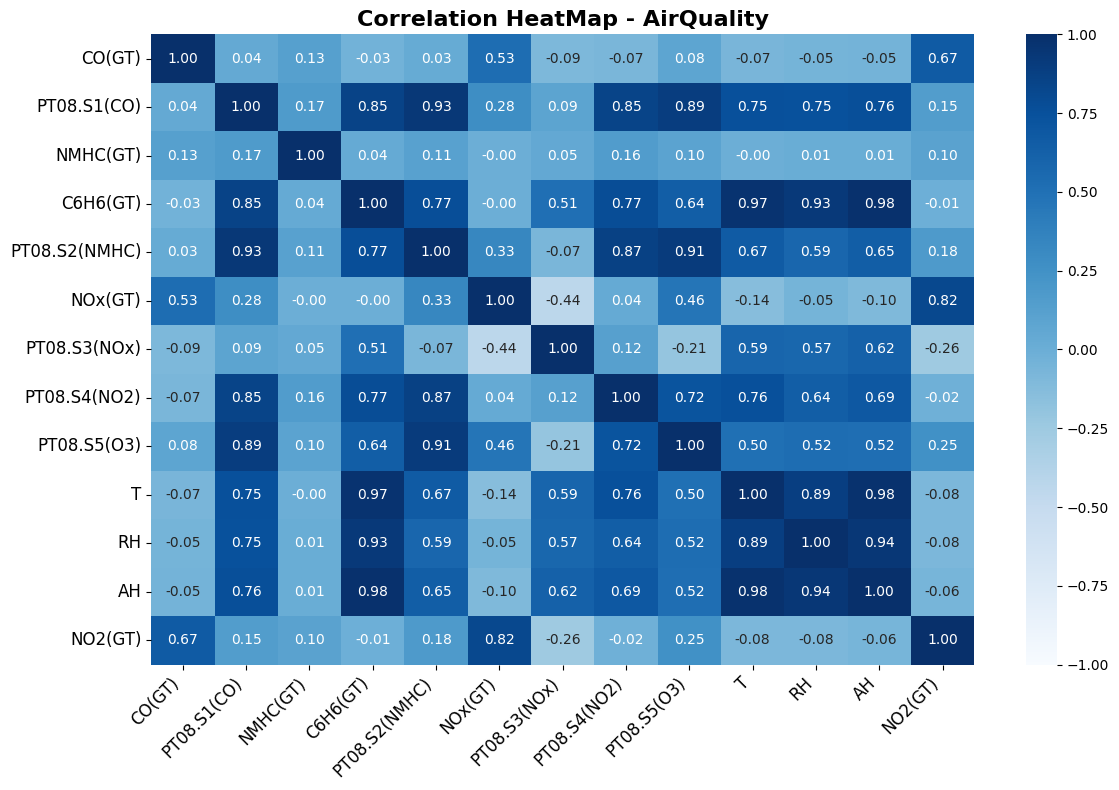

In [ ]:
# Calculate the correlation matrix
correlation = df[["CO(GT)", "PT08.S1(CO)", "NMHC(GT)", "C6H6(GT)", "PT08.S2(NMHC)", "NOx(GT)", "PT08.S3(NOx)", "PT08.S4(NO2)", "PT08.S5(O3)", "T", "RH", "AH", "NO2(GT)" ]].corr()

# Set the figure size for better readability
plt.figure(figsize=(12, 8))

# Create the heatmap with better formatting
sns.heatmap(
    correlation,
    annot=True,
    cmap="Blues",
    vmin=-1,
    vmax=1,
    annot_kws={"size": 10},  # Adjust annotation font size
    fmt=".2f"  # Display correlation values with 2 decimal places
)

# Set the title with larger font size
plt.title("Correlation HeatMap - AirQuality", fontsize=16, weight='bold')

# Customize the axis tick font sizes
plt.xticks(fontsize=12, rotation=45, ha="right")
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()  # Automatically adjust the layout for better appearance
plt.show()


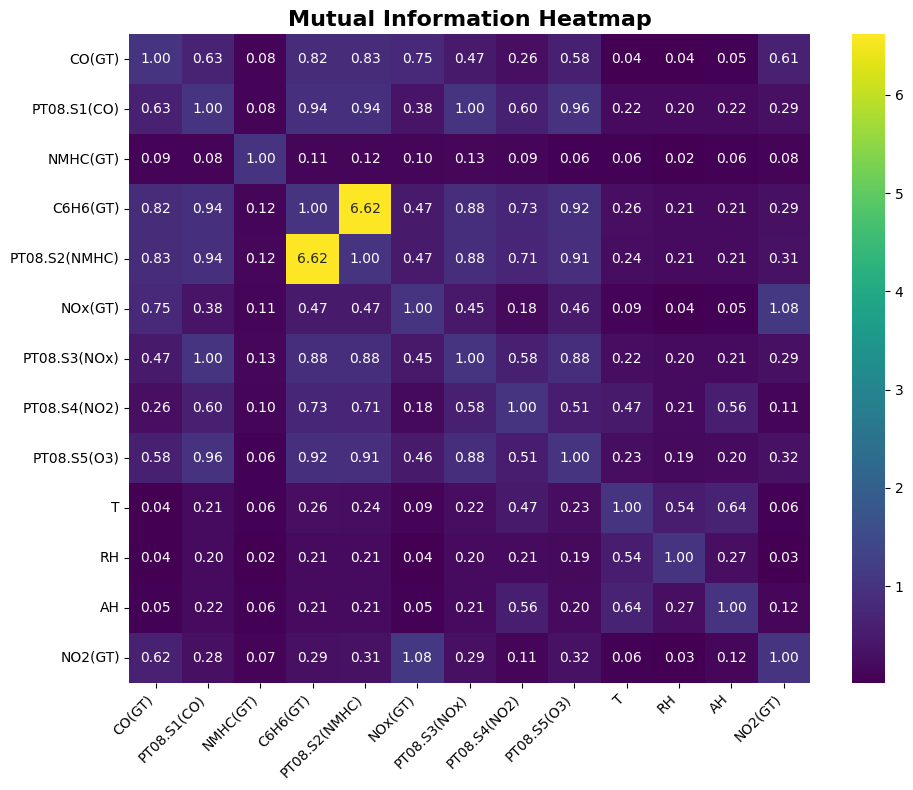

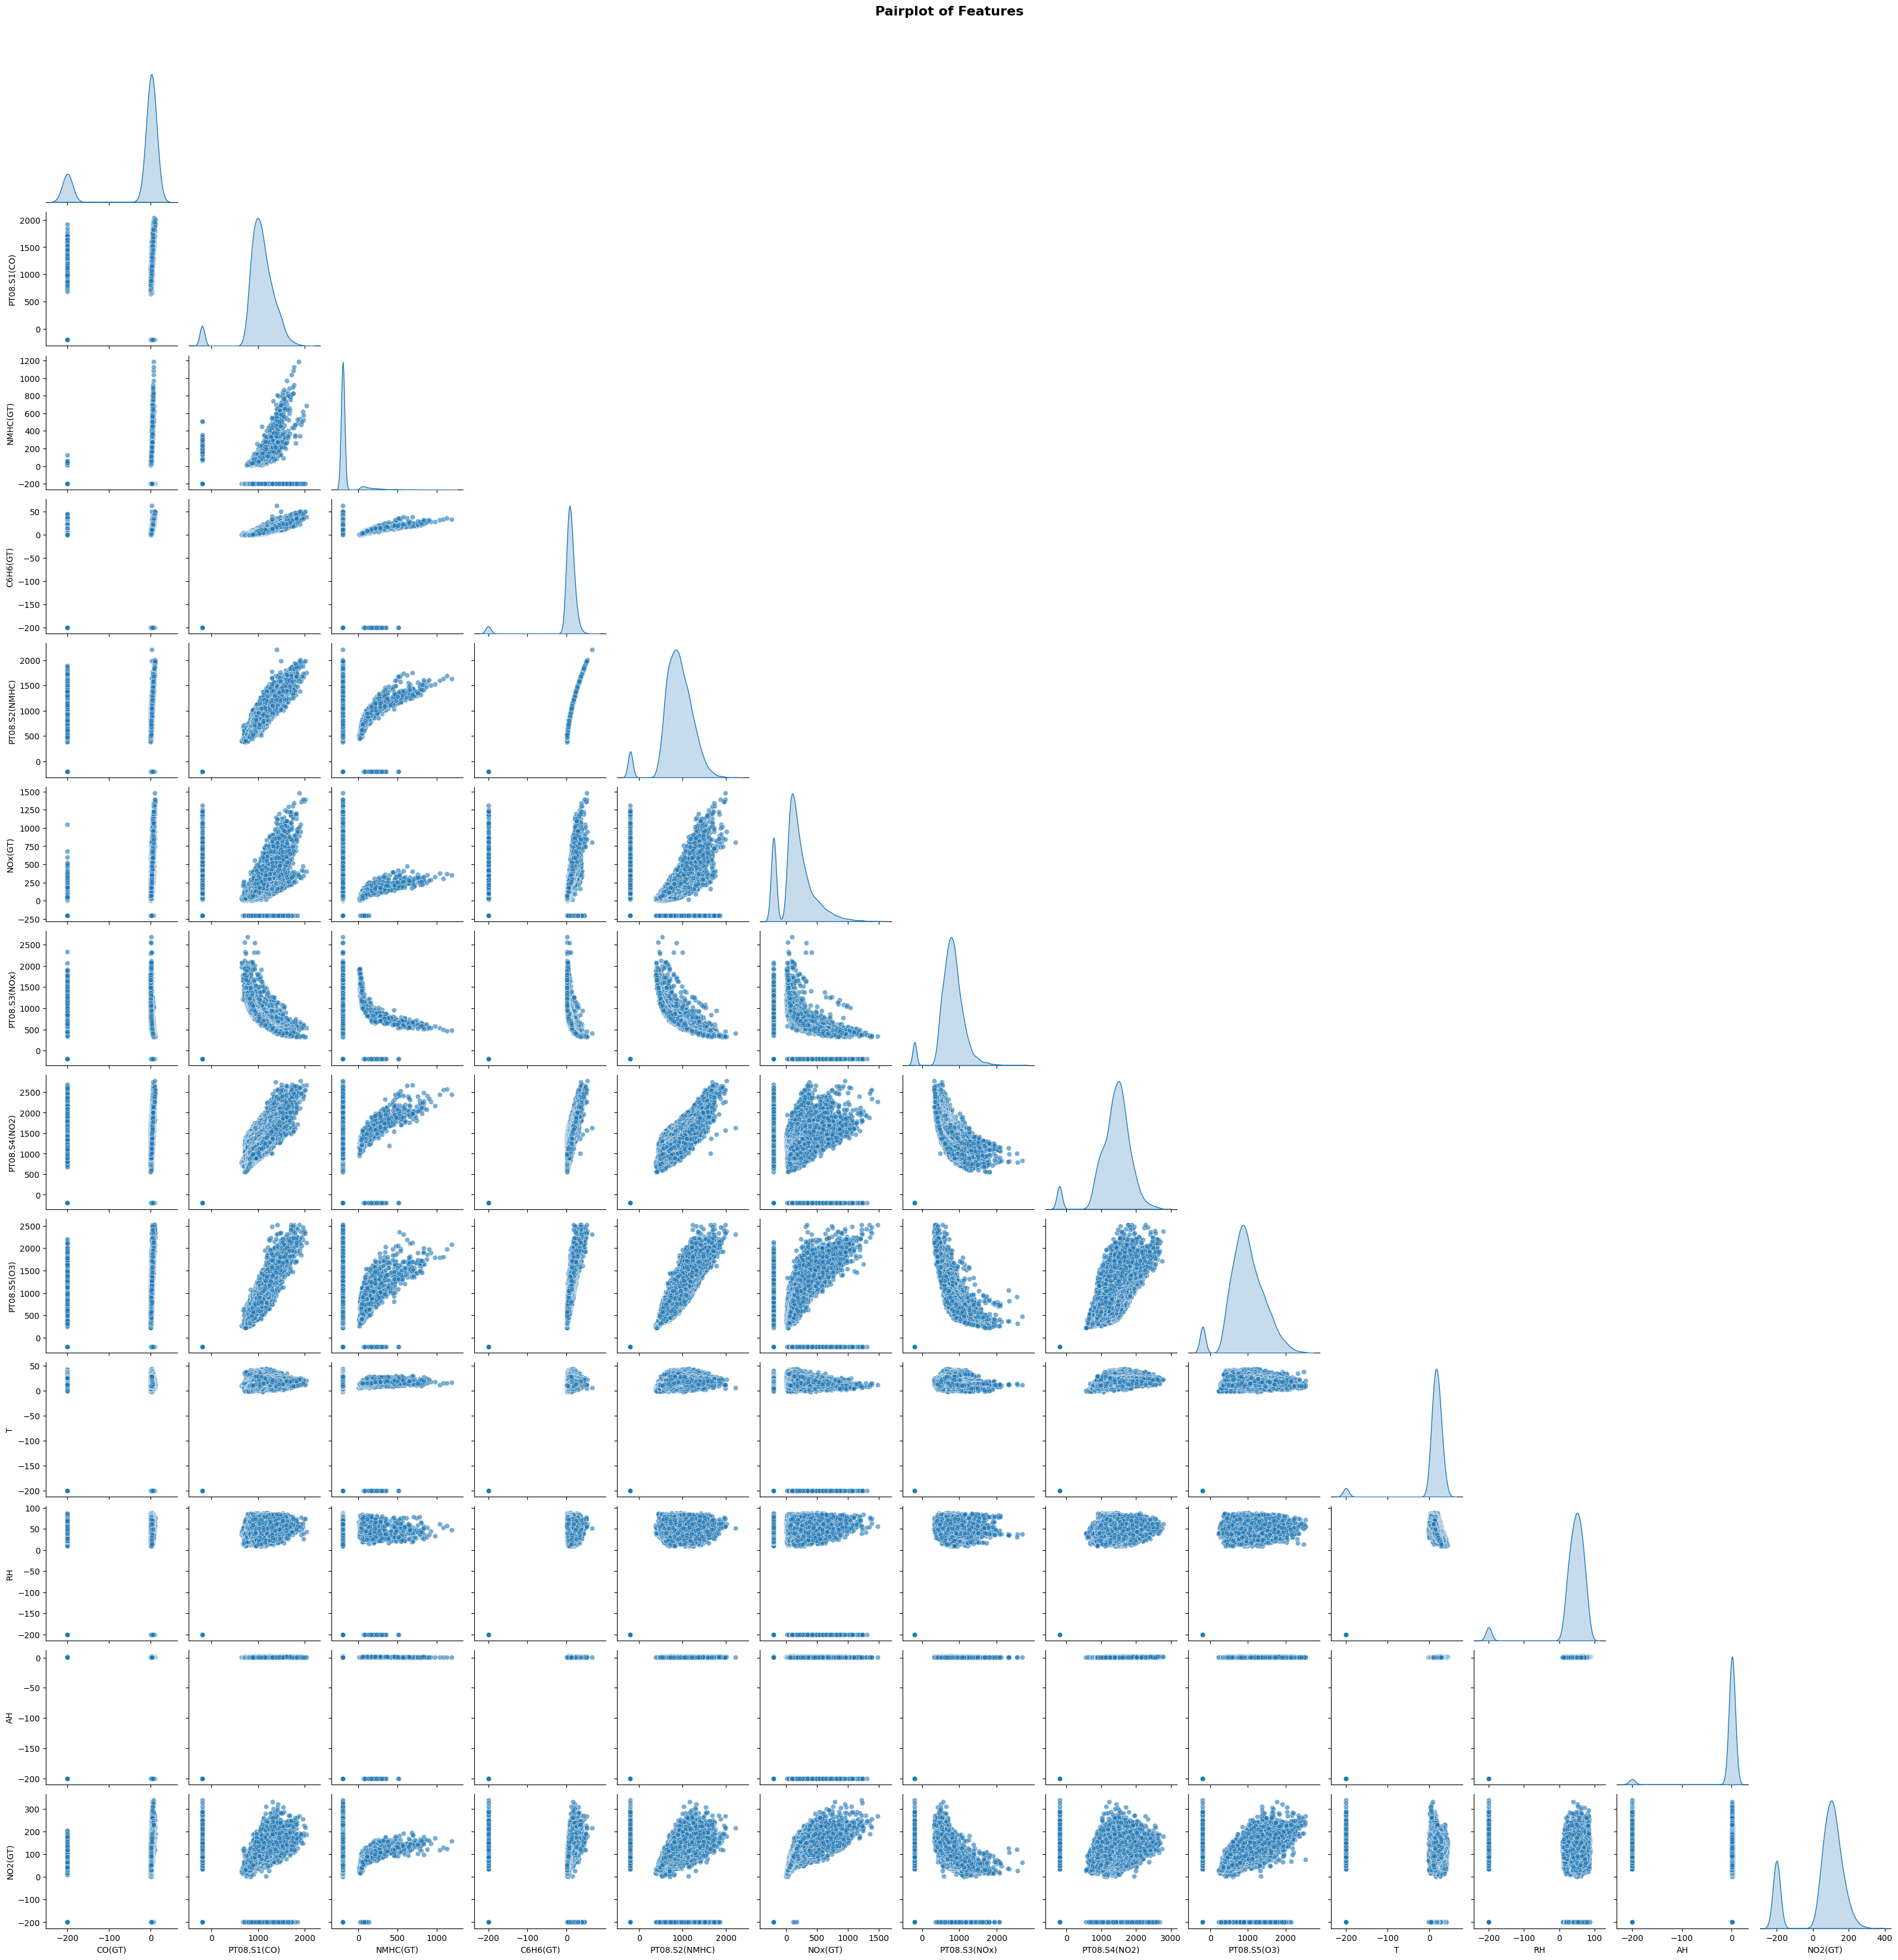

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression

def plot_nonlinear_relationships(file_path):
    # Load the dataset (auto-detect CSV vs Excel)
    if file_path.endswith('.csv'):
        df = pd.read_csv(file_path)
    elif file_path.endswith('.xlsx'):
        df = pd.read_excel(file_path)
    else:
        raise ValueError("Unsupported file format. Use CSV or Excel.")

    # Select the features of interest
    features = ["CO(GT)", "PT08.S1(CO)", "NMHC(GT)", "C6H6(GT)", "PT08.S2(NMHC)",
                "NOx(GT)", "PT08.S3(NOx)", "PT08.S4(NO2)", "PT08.S5(O3)",
                "T", "RH", "AH", "NO2(GT)"]

    # Ensure selected features exist in the dataframe
    df = df[[col for col in features if col in df.columns]].copy()

    # Drop NaN values (or replace with mean if needed)
    df = df.dropna()  # Use df.fillna(df.mean()) for mean imputation

    # Calculate mutual information
    mi_matrix = pd.DataFrame(index=df.columns, columns=df.columns, dtype=float)
    for col1 in df.columns:
        for col2 in df.columns:
            if col1 == col2:
                mi_matrix.loc[col1, col2] = 1.0  # Self-information
            else:
                mi = mutual_info_regression(df[[col1]], df[col2], random_state=73)
                mi_matrix.loc[col1, col2] = mi[0]

    # Plot mutual information heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(mi_matrix.astype(float), annot=True, cmap="viridis", fmt=".2f")
    plt.title("Mutual Information Heatmap", fontsize=16, weight='bold')
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # Pairplot to visualize relationships
    sns.pairplot(df, diag_kind="kde", plot_kws={"alpha": 0.6}, corner=True)
    plt.suptitle("Pairplot of Features", fontsize=16, weight='bold', y=1.02)
    plt.show()

# Example usage
file_path = '/content/AirQualityUCI.xlsx'  # Replace with correct file path
plot_nonlinear_relationships(file_path)


## Normalize

In [ ]:
scaler = MinMaxScaler()
df = df.drop(['Time','Date'], axis=1)
# Exclude the target column 'custcat' from normalization
features = [col for col in df.columns]
df[features] = scaler.fit_transform(df[features])
print(df.head())

     CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)   NOx(GT)  \
0  0.956111     0.696506  0.251980  0.803369       0.515949  0.217987   
1  0.953280     0.666257  0.224622  0.793949       0.478355  0.180465   
2  0.954224     0.715258  0.207343  0.792434       0.471935  0.197141   
3  0.954224     0.703427  0.201584  0.793310       0.475663  0.221560   
4  0.951392     0.657328  0.180706  0.783033       0.428956  0.197141   

   PT08.S3(NOx)   NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)         T        RH  \
0      0.435782  0.579952      0.635966     0.538977  0.873262  0.861979   
1      0.476541  0.541041      0.591176     0.430539  0.872036  0.857910   
2      0.464834  0.581805      0.589748     0.467909  0.866312  0.879643   
3      0.448183  0.596628      0.599580     0.515380  0.862633  0.900511   
4      0.487382  0.585510      0.568067     0.481131  0.863246  0.899039   

         AH  
0  0.992715  
1  0.992555  
2  0.992678  
3  0.992858  
4  0.992868  


----- Epoch 1 -----
Epoch 1/50 - Train Loss: 0.2905 - Validation Loss: 0.2814

----- Epoch 2 -----
Epoch 2/50 - Train Loss: 0.2904 - Validation Loss: 0.2813

----- Epoch 3 -----
Epoch 3/50 - Train Loss: 0.2903 - Validation Loss: 0.2812

----- Epoch 4 -----
Epoch 4/50 - Train Loss: 0.2902 - Validation Loss: 0.2811

----- Epoch 5 -----
Epoch 5/50 - Train Loss: 0.2902 - Validation Loss: 0.2810

----- Epoch 6 -----
Epoch 6/50 - Train Loss: 0.2901 - Validation Loss: 0.2810

----- Epoch 7 -----
Epoch 7/50 - Train Loss: 0.2900 - Validation Loss: 0.2809

----- Epoch 8 -----
Epoch 8/50 - Train Loss: 0.2899 - Validation Loss: 0.2808

----- Epoch 9 -----
Epoch 9/50 - Train Loss: 0.2898 - Validation Loss: 0.2807

----- Epoch 10 -----
Epoch 10/50 - Train Loss: 0.2898 - Validation Loss: 0.2806

----- Epoch 11 -----
Epoch 11/50 - Train Loss: 0.2897 - Validation Loss: 0.2806

----- Epoch 12 -----
Epoch 12/50 - Train Loss: 0.2896 - Validation Loss: 0.2805

----- Epoch 13 -----
Epoch 13/50 - Train Loss:

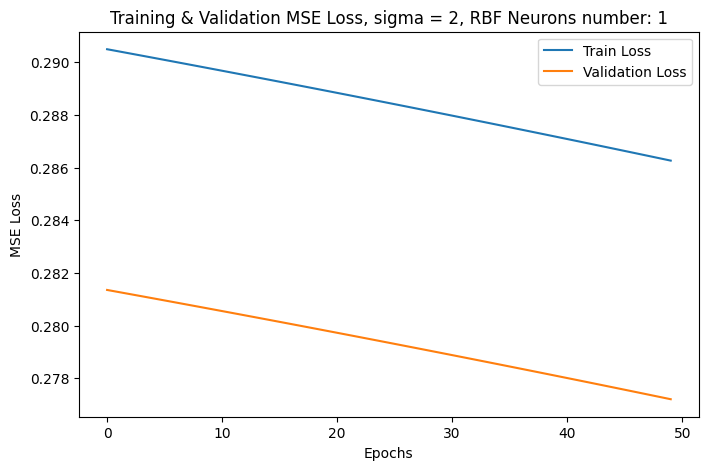

Test MSE Loss: 0.28766697574762684


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

class RBFNetwork:
    def __init__(self, input_size, hidden_size, output_size, sigma=1.0, lr=0.1):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.sigma = sigma
        self.lr = lr
        self.centers = np.random.randn(hidden_size, input_size)
        self.weights = np.random.randn(hidden_size, output_size)


    def rbf_activation(self, X):

        N = X.shape[0]
        rbf_outputs = np.zeros((N, self.hidden_size))

        for i in range(self.hidden_size):
            diff = X - self.centers[i]
            dist_sq = np.sum(diff ** 2, axis=1)
            rbf_outputs[:, i] = np.exp(-dist_sq / (2 * (self.sigma ** 2)))



        return rbf_outputs

    def forward(self, X):

        hidden_output = self.rbf_activation(X)
        output = hidden_output.dot(self.weights)
        return output, hidden_output

    def compute_loss(self, y_true, y_pred):

        loss = np.mean((y_true - y_pred) ** 2)
        return loss

    def backward(self, X, y_true, y_pred, hidden_output):

        if y_pred.ndim == 2 and y_pred.shape[1] == 1:
            y_pred = y_pred.ravel()
        if y_true.ndim == 2 and y_true.shape[1] == 1:
            y_true = y_true.ravel()

        N = X.shape[0]

        error = (y_true - y_pred)

        dW = -(2.0 / N) * hidden_output.T.dot(error[:, np.newaxis])



        self.weights -= self.lr * dW



        dL_dCenters = np.zeros_like(self.centers)

        for i in range(self.hidden_size):
            diff = X - self.centers[i]
            dist_sq = np.sum(diff**2, axis=1)
            rbf_vals = np.exp(-dist_sq / (2 * self.sigma**2))


            grad_center = np.zeros(self.input_size)
            for n in range(N):
                grad_center += error[n] * rbf_vals[n] * diff[n] / (self.sigma**2)


            grad_center *= -(2.0 / N)


            dL_dCenters[i] = grad_center



        self.centers -= self.lr * dL_dCenters


    def train(self, X_train, y_train, X_val, y_val, epochs=50):
        train_losses = []
        val_losses = []


        if y_train.ndim == 2 and y_train.shape[1] == 1:
            y_train = y_train.ravel()
        if y_val.ndim == 2 and y_val.shape[1] == 1:
            y_val = y_val.ravel()

        for epoch in range(epochs):
            print(f"----- Epoch {epoch+1} -----")


            y_train_pred, hidden_train = self.forward(X_train)

            y_val_pred, _ = self.forward(X_val)


            if y_train_pred.ndim == 2 and y_train_pred.shape[1] == 1:
                y_train_pred = y_train_pred.ravel()
            if y_val_pred.ndim == 2 and y_val_pred.shape[1] == 1:
                y_val_pred = y_val_pred.ravel()


            train_loss = self.compute_loss(y_train, y_train_pred)
            val_loss = self.compute_loss(y_val, y_val_pred)

            train_losses.append(train_loss)
            val_losses.append(val_loss)


            self.backward(X_train, y_train, y_train_pred, hidden_train)

            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}\n")


        return train_losses, val_losses


if __name__ == "__main__":

    df = pd.read_excel('/content/AirQualityUCI.xlsx')

    target_column = "NO2(GT)"
    df = df.drop(['Time','Date','C6H6(GT)','PT08.S4(NO2)', 'T',"RH",'AH',], axis=1)


    scaler = MinMaxScaler()

    features = [col for col in df.columns]
    df[features] = scaler.fit_transform(df[features])

    X_df = df.drop(columns=[target_column])
    y_df = df[target_column]

    X = X_df.to_numpy()
    y = y_df.to_numpy()

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=73)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state = 73)

    sigma = 2
    hidden_size = 1
    rbf_model = RBFNetwork(input_size=7, hidden_size=hidden_size, output_size=1, sigma=sigma, lr=0.01)


    train_losses, val_losses = rbf_model.train(X_train, y_train, X_val, y_val, epochs=50)

    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.title(f"Training & Validation MSE Loss, sigma = {sigma}, RBF Neurons number: {hidden_size}")
    plt.xlabel("Epochs")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.show()


    y_test_pred, _ = rbf_model.forward(X_test)


    if y_test_pred.ndim == 2 and y_test_pred.shape[1] == 1:
        y_test_pred = y_test_pred.ravel()

    test_loss = rbf_model.compute_loss(y_test, y_test_pred)
    print("Test MSE Loss:", test_loss)


In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def normalize_excel(file_path, output_path="normalized_data.xlsx"):
    # Read the Excel file
    df = pd.read_excel(file_path)

    # Select only numerical columns
    numerical_cols = df.select_dtypes(include=['number']).columns

    # Initialize the MinMaxScaler (0 to 1 normalization)
    scaler = MinMaxScaler(feature_range=(0, 1))

    # Fill missing values with column min (alternative: df.fillna(df.mean()))
    df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].min())

    # Apply normalization
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

    # Save the normalized data to a new Excel file
    df.to_excel(output_path, index=False)

    print(f"✅ Normalized data saved to: {output_path}")

# Example usage
file_path = "/content/AirQualityUCI2.xlsx"  # Replace with your file path
normalize_excel(file_path)


✅ Normalized data saved to: normalized_data.xlsx
